In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

## LOAD DATASET

In [2]:
# GENERATE DATA FROM STABLE DISTRI
def alpha_stable(alpha, beta, gamma, delta, n):
    V = math.pi / 2 * (2 * np.random.rand(n, 1) - 1)
    W = - np.log(np.random.rand(n, 1))
    r = np.zeros(n)

    for i in range(n):
        if alpha != 1:
            const = beta * math.tan(math.pi * alpha / 2)
            b = math.atan(const)
            s = (1 + const * const)**(1 / (2 * alpha))
            r[i] = s * math.sin(alpha * V[i] + b) / ((math.cos(V[i])) ** (1/alpha)) * (( math.cos( (1-alpha) * V[i] - b ) / W[i] )**((1-alpha)/alpha))
            r[i] = gamma * r[i] + delta
        else:
            piover2 = math.pi / 2
            sclshftV = piover2 + beta * V[i]
            r[i] = 1/piover2 * (sclshftV * math.tan(V[i]) - beta * np.log( (piover2 * W[i] * math.cos(V[i]) ) / sclshftV ))
            r[i] = gamma * r[i] + (2 / math.pi) * beta * gamma * np.log(gamma) + delta
    return r

actual_data = alpha_stable(1.5, 0.5, 1, 0, 200)

In [6]:
# CALCULATE SUMMARY STATS

def alpha_stable_ss(data):
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.30827333, 0.42665285, 0.86005218, 0.4655982 ])

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [7]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.gamma_samples = 20
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.num_latent = np.shape(actual_summary_statistics)[0]
        self.lambda_dim = (self.num_coeffs) + int(((self.num_coeffs) * ((self.num_coeffs) + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    # def summary_statistics(self, theta):
    #     n_datasets = []
    #     n_summary_statistics = []
    #     for i in range(self.num_datasets):
    #         n_datasets.append(alpha_stable(theta[0], theta[1], theta[2], theta[3], 200))
    #         n_summary_statistics.append(alpha_stable_ss(n_datasets[i]))

    #     sample_mean = np.mean(n_summary_statistics, axis = 0)
    #     sample_variance = np.cov(np.array(n_summary_statistics).T)

    #     return sample_mean, sample_variance

    def mean_adjustment_summary_statistics(self, adjusted_theta):
        theta = adjusted_theta[0:self.num_coeffs]
        Gamma = adjusted_theta[-self.num_latent:]
        n_datasets = []
        n_summary_statistics = []
        for i in range(self.num_datasets):
            n_datasets.append(alpha_stable(theta[0], theta[1], theta[2], theta[3], 200))
            n_summary_statistics.append(alpha_stable_ss(n_datasets[i]))

        sample_mean = np.mean(n_summary_statistics, axis = 0)
        sample_variance = np.cov(np.array(n_summary_statistics).T)
        adjusted_sample_mean = sample_mean + np.diag(np.sqrt(sample_variance)) @ Gamma

        return adjusted_sample_mean, sample_variance

    def theta_prior(self, theta): 
        log_prior = multivariate_normal.logpdf(theta, cov= 100 * np.identity(self.num_coeffs))
        
        return log_prior

    def Gamma_prior(self, Gamma, scale):
        log_prior_gamma = []
        for j in range(len(Gamma)):
            log_prior_gamma.append(-np.log(2 * scale)-1/scale * np.abs(Gamma[j]))
        log_prior_Gamma = np.sum(log_prior_gamma)
        return log_prior_gamma, log_prior_Gamma

    # def unbiased_log_likelihood(self, theta):
    #     sample_mean = self.summary_statistics(theta)[0]
    #     sample_variance = self.summary_statistics(theta)[1]
    #     diff_mean_s = self.actual_summary_statistics - sample_mean
    #     part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    #     u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    #     return u_est_log_likelihood

    def mean_adjustment_unbiased_log_likelihood(self, adjusted_theta):
        adjusted_sample_mean = self.mean_adjustment_summary_statistics(adjusted_theta)[0]
        sample_variance = self.mean_adjustment_summary_statistics(adjusted_theta)[1]
        diff_mean_s = self.actual_summary_statistics - adjusted_sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
        ma_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - (self.num_coeffs + self.num_latent) - 2) / (2 * (self.num_datasets-1)) * part1
        return ma_u_est_log_likelihood

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(1 / np.diag(l)) - np.matmul(((np.reshape(theta - mu, ((self.num_coeffs),1))) * theta - mu), l)).T[np.triu_indices((self.num_coeffs))] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:(self.num_coeffs)])
        c_vech_l = np.array(c[(self.num_coeffs):])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        #mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * (self.num_coeffs))
        l_0 = np.tril(np.identity((self.num_coeffs)) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices((self.num_coeffs))]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    # GENERATE THETA
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    ma_unbiased_log_likelihood_init = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma_init = np.random.laplace(scale = 0.5, size = self.num_latent)
                        adjusted_theta_0 = np.concatenate((theta_0, Gamma_init))
                        ma_unbiased_log_likelihood_init.append(self.mean_adjustment_unbiased_log_likelihood(adjusted_theta_0))
                    # Find gradient of LB
                    h_lambda_init = self.theta_prior(theta_tilde_0) + np.mean(ma_unbiased_log_likelihood_init) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    ma_unbiased_log_likelihood = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma = np.random.laplace(scale = 0.5, size = self.num_latent)
                        adjusted_theta_q = np.concatenate((theta_q, Gamma))
                        ma_unbiased_log_likelihood.append(self.mean_adjustment_unbiased_log_likelihood(adjusted_theta_q))

                    # Find gradient of LB
                    h_lambda = self.theta_prior(theta_tilde_q) + np.mean(ma_unbiased_log_likelihood) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [8]:
# Set hyperparameters
stop = 500

In [9]:
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  2%|▏         | 1/50 [1:23:48<68:26:48, 5028.75s/it]

LB -25.555353548603406


  4%|▍         | 2/50 [2:47:57<67:12:34, 5040.72s/it]

LB -25.5657829391494


  6%|▌         | 3/50 [4:14:31<66:43:11, 5110.47s/it]

LB -25.334184950498948


  8%|▊         | 4/50 [69:09:29<1218:25:07, 95354.51s/it]

LB -24.886675858146408


 10%|█         | 5/50 [70:42:53<787:22:18, 62989.74s/it] 

LB -26.06441702693007


 12%|█▏        | 6/50 [73:22:51<548:00:02, 44836.42s/it]

LB -25.633149935013247


 14%|█▍        | 7/50 [77:01:10<411:36:45, 34460.60s/it]

LB -25.180803301929718


 16%|█▌        | 8/50 [93:17:06<491:32:08, 42131.63s/it]

LB -25.417033405785286


 18%|█▊        | 9/50 [94:56:28<351:03:13, 30824.24s/it]

LB -25.471764112364134


 20%|██        | 10/50 [100:25:17<304:26:03, 27399.08s/it]

LB -25.232738288160846


 22%|██▏       | 11/50 [101:47:25<222:19:13, 20521.88s/it]

LB -25.081055283974028


 22%|██▏       | 11/50 [102:53:14<364:46:58, 33672.26s/it]


KeyboardInterrupt: 

In [7]:
LB_estimate

[-13.159637911947367,
 -12.824708468635475,
 -12.948728137463728,
 -12.911101328171407,
 -13.074139314718902,
 -12.955143348956952,
 -13.019012526404037,
 -13.100310934058003,
 -12.977048595391944,
 -13.026575911214886,
 -12.883314921220355,
 -13.070680810653027,
 -12.906108360899845,
 -12.954201654613438,
 -13.228833543314703,
 -12.828377411994376,
 -13.07042623155385,
 -12.961475342399012,
 -12.827377008879047,
 -13.052856707963583,
 -12.766333745009005,
 -12.866457455472146,
 -12.935428677065293,
 -12.98359731954739,
 -12.872622033232487,
 -12.86609405247848,
 -12.887479099495325,
 -12.734165830592447,
 -12.903720858527999,
 -12.86415284159431,
 -12.818422040486336,
 -12.902183377016101,
 -12.823170718067377,
 -12.854146415156503,
 -12.755660464071402,
 -12.837561277708827,
 -13.003909619469765,
 -12.860650347398128,
 -12.972752103516164,
 -12.948898004671538,
 -12.709457619383063,
 -12.935282438808999,
 -13.019807517380471,
 -12.801157375284525,
 -12.827350091624623,
 -12.857685474

In [8]:
best_lambda

array([array([-0.154448  ,  0.10269723, -0.01320164,  0.14740026]),
       array([10.28201011,  0.35680262,  0.26847097,  0.20109738,  9.63399731,
              -0.26846429, -0.27138821, 10.21994753,  0.12974358,  9.63558214])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

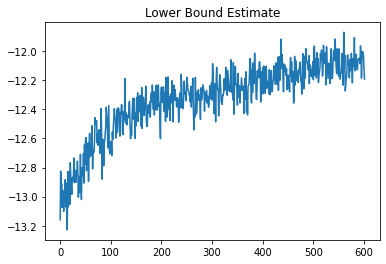

In [10]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

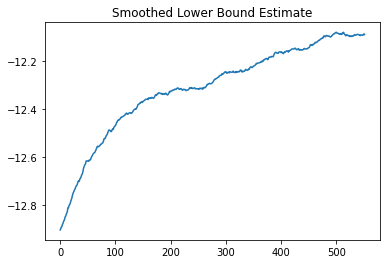

In [11]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [32]:
best_mu = best_lambda[0]

best_l = np.zeros((4, 4))
best_l[:, 0] = best_lambda[1][0:4]
best_l[1:4, 1] = best_lambda[1][4:7]
best_l[2:4, 2] = best_lambda[1][7:9]
best_l[3:4, 3] = best_lambda[1][9:10]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.51639407, 0.05072245, 0.99393869, 0.14615292])

Text(0.5, 1.0, 'Posterior density of alpha')

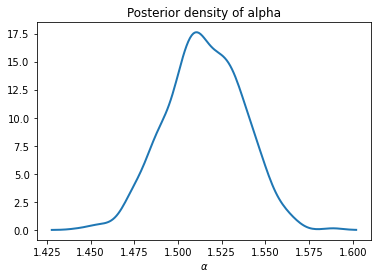

In [31]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde = gaussian_kde(best_alpha)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

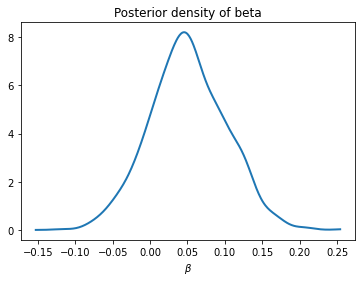

In [33]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde = gaussian_kde(best_beta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

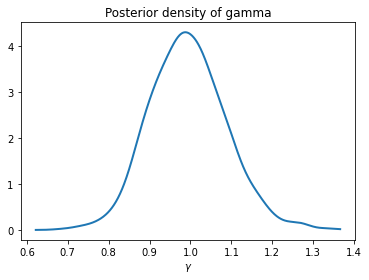

In [34]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde = gaussian_kde(best_gamma)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

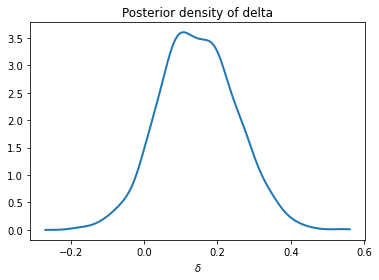

In [35]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde = gaussian_kde(best_delta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')